Problem Statement

"Identify natural clusters and detect anomalies in historical stock price data using a hybrid clustering approach combining KMeans and DBSCAN."

Goal: Group stocks or stock-days with similar behavior while detecting unusual patterns/outliers.

Data: Historical stock prices (Open, Close, High, Low, Volume) from NASDAQ or NSE.

Approach: Use KMeans to form initial clusters, then refine with DBSCAN to detect noise/outliers.

Hybrid KMeans + DBSCAN – Core Idea

Why Hybrid:

KMeans finds general clusters quickly but can misclassify outliers.

DBSCAN detects irregular shapes and noise but struggles with large dense data.

Hybrid: KMeans provides initial clusters, DBSCAN refines clusters and flags anomalies.

Steps:

Apply KMeans → assign initial clusters.

Apply DBSCAN within each KMeans cluster to detect local noise and refine cluster boundaries.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the stock data CSV
data = pd.read_csv("NASDAQ.csv")

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Display first 5 rows
print(data.head())

        Date  Close/Last      Open      High       Low
0 2025-08-29    21455.55  21630.33  21631.15  21397.98
1 2025-08-28    21705.16  21619.27  21742.46  21534.94
2 2025-08-27    21590.14  21526.33  21616.17  21476.30
3 2025-08-26    21544.27  21443.63  21550.92  21389.10
4 2025-08-25    21449.29  21466.47  21572.18  21400.08


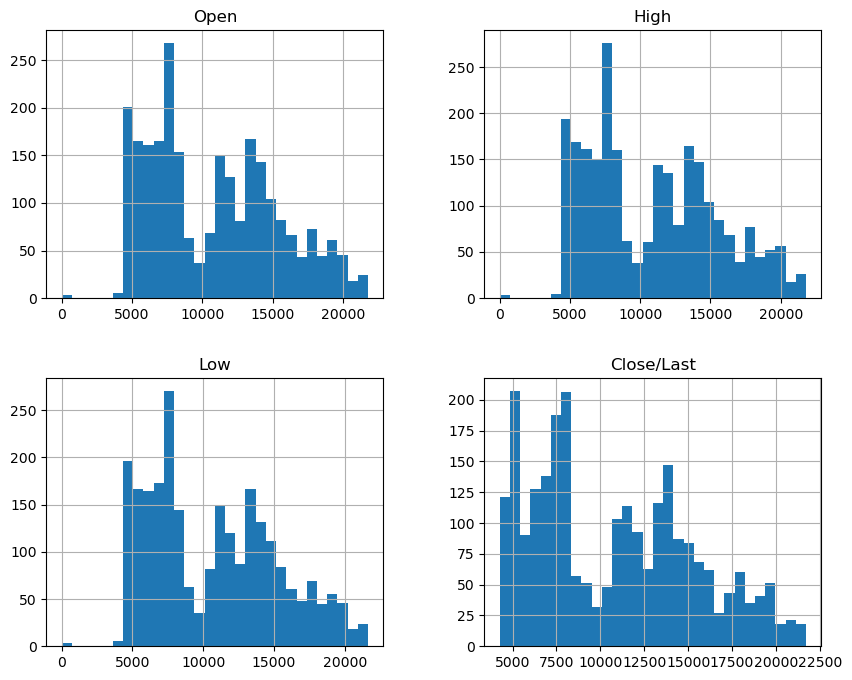

In [4]:

# Histogram for numerical features
data[['Open', 'High', 'Low', 'Close/Last']].hist(bins=30, figsize=(10,8))
plt.show()

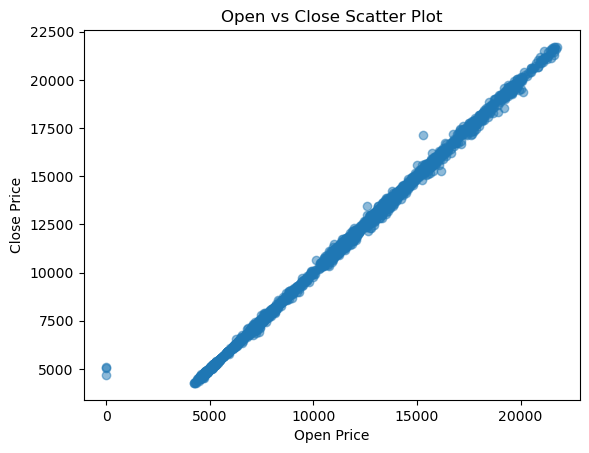

In [5]:
# Scatter plot: Open vs Close
plt.scatter(data['Open'], data['Close/Last'], alpha=0.5)
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.title('Open vs Close Scatter Plot')
plt.show()


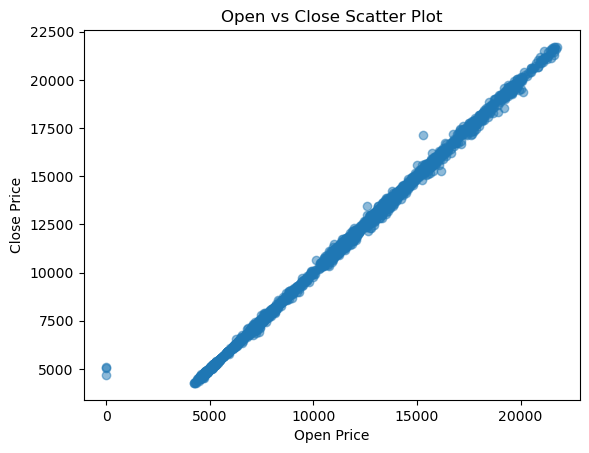

In [6]:
# Scatter plot: Open vs Close
plt.scatter(data['Open'], data['Close/Last'], alpha=0.5)
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.title('Open vs Close Scatter Plot')
plt.show()

In [7]:
import numpy as np

# Use only numerical features
X = data[['Open', 'High', 'Low', 'Close/Last']].values

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# KMeans parameters
k = 3  # number of clusters
max_iter = 100

# Step 1: Initialize centroids randomly
np.random.seed(42)
centroids = X[np.random.choice(len(X), k, replace=False)]

for i in range(max_iter):
    # Step 2: Assign points to nearest centroid
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances, axis=0)
    
    # Step 3: Update centroids
    new_centroids = np.array([X[labels==j].mean(axis=0) for j in range(k)])
    
    # Check for convergence
    if np.allclose(centroids, new_centroids):
        break
    centroids = new_centroids

print("KMeans centroids:\n", centroids)


KMeans centroids:
 [[-0.90107164 -0.90246171 -0.89971147 -0.90181438]
 [ 1.57713968  1.57613204  1.57844722  1.57968607]
 [ 0.44084316  0.4432712   0.43830397  0.44057334]]


In [8]:
from collections import deque

eps = 0.5
min_samples = 5

n = X.shape[0]
labels_db = np.full(n, -1)  # initialize all points as noise (-1)
cluster_id = 0

def neighbors(point_idx):
    dist = np.sqrt(((X - X[point_idx])**2).sum(axis=1))
    return np.where(dist <= eps)[0]

for i in range(n):
    if labels_db[i] != -1:
        continue
    neigh = neighbors(i)
    if len(neigh) < min_samples:
        labels_db[i] = -1  # noise
        continue
    # Expand cluster
    labels_db[i] = cluster_id
    queue = deque(neigh)
    while queue:
        j = queue.popleft()
        if labels_db[j] == -1:
            labels_db[j] = cluster_id
        if labels_db[j] != -1:
            continue
        labels_db[j] = cluster_id
        neigh_j = neighbors(j)
        if len(neigh_j) >= min_samples:
            queue.extend(neigh_j)
    cluster_id += 1

print("DBSCAN clusters assigned:\n", np.unique(labels_db))


DBSCAN clusters assigned:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [9]:
hybrid_labels = np.full(n, -1)
hybrid_cluster_id = 0

for km_label in range(k):
    idx = np.where(labels == km_label)[0]
    X_cluster = X[idx]
    
    # DBSCAN on this cluster
    n_cluster = X_cluster.shape[0]
    cluster_labels = np.full(n_cluster, -1)
    local_cluster_id = 0
    
    for i in range(n_cluster):
        if cluster_labels[i] != -1:
            continue
        neigh = np.sqrt(((X_cluster - X_cluster[i])**2).sum(axis=1)) <= eps
        neigh_idx = np.where(neigh)[0]
        if len(neigh_idx) < min_samples:
            cluster_labels[i] = -1
            continue
        cluster_labels[i] = local_cluster_id
        queue = deque(neigh_idx)
        while queue:
            j = queue.popleft()
            if cluster_labels[j] == -1:
                cluster_labels[j] = local_cluster_id
            if cluster_labels[j] != -1:
                continue
            cluster_labels[j] = local_cluster_id
            neigh_j = np.sqrt(((X_cluster - X_cluster[j])**2).sum(axis=1)) <= eps
            neigh_idx_j = np.where(neigh_j)[0]
            if len(neigh_idx_j) >= min_samples:
                queue.extend(neigh_idx_j)
        local_cluster_id += 1
    
    # Assign to hybrid_labels
    for i, idx_val in enumerate(idx):
        if cluster_labels[i] != -1:
            hybrid_labels[idx_val] = hybrid_cluster_id + cluster_labels[i]
    hybrid_cluster_id += local_cluster_id

print("Hybrid clusters with anomalies detected:\n", np.unique(hybrid_labels))


Hybrid clusters with anomalies detected:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


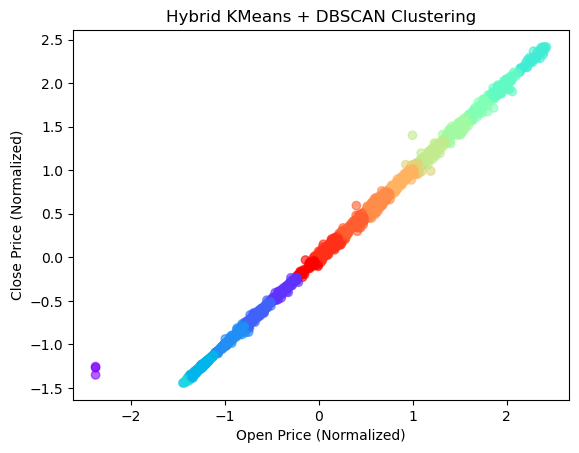

In [10]:
plt.scatter(X[:,0], X[:,3], c=hybrid_labels, cmap='rainbow', alpha=0.6)
plt.xlabel('Open Price (Normalized)')
plt.ylabel('Close Price (Normalized)')
plt.title('Hybrid KMeans + DBSCAN Clustering')
plt.show()


In [11]:
# Using same X (normalized numerical features)
k = 3
max_iter = 100
np.random.seed(42)

# Step 1: Randomly initialize centroids
centroids = X[np.random.choice(len(X), k, replace=False)]
print("Initial centroids:\n", centroids)

for i in range(max_iter):
    # Step 2: Assign points to nearest centroid (Euclidean distance)
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances, axis=0)  # nearest centroid index
    
    # Step 3: Update centroids (mean of assigned points)
    new_centroids = np.array([X[labels==j].mean(axis=0) for j in range(k)])
    
    # Step 4: Check convergence
    if np.allclose(centroids, new_centroids):
        print(f"Converged after {i} iterations")
        break
    centroids = new_centroids

print("Final centroids:\n", centroids)


Initial centroids:
 [[-1.21321177 -1.2129459  -1.20812352 -1.21230902]
 [ 0.90308929  0.90728413  0.92066642  0.92397222]
 [-0.21714216 -0.22705781 -0.23694551 -0.23003529]]
Converged after 14 iterations
Final centroids:
 [[-0.90107164 -0.90246171 -0.89971147 -0.90181438]
 [ 1.57713968  1.57613204  1.57844722  1.57968607]
 [ 0.44084316  0.4432712   0.43830397  0.44057334]]


Explanation:

distances calculates 
∥
𝑥
−
𝜇
𝑖
∥
∥x−μ
i ∥ for all points and centroids.

labels assigns each point to its nearest centroid.

new_centroids updates the centroid positions as the mean of all points in that cluster.

DBSCAN – Core Mathematics

Goal: Detect dense regions (clusters) and outliers in data without specifying k.

Definitions:

ε-neighborhood: Points within distance eps of point 
Ne(xi) = {xj| ||xi - xj|| <= ε}

Core Point:
|N_\epsilon(x_i)| \ge \text{min_samples} → point is a core of a cluster.

Border Point: Within ε-neighborhood of a core point but less than min_samples neighbors.

Noise: Not a core or border point.

Algorithm Steps:

For each point, find its ε-neighborhood.

If point is a core point, expand cluster by recursively including neighbors.

Points not included → noise.

In [13]:
from collections import deque

eps = 0.5
min_samples = 5
n = X.shape[0]
labels_db = np.full(n, -1)  # initialize all points as noise
cluster_id = 0

def neighbors(point_idx):
    # Euclidean distance to all points
    dist = np.sqrt(((X - X[point_idx])**2).sum(axis=1))
    return np.where(dist <= eps)[0]

for i in range(n):
    if labels_db[i] != -1:
        continue
    neigh = neighbors(i)
    if len(neigh) < min_samples:
        labels_db[i] = -1  # noise
        continue
    # Expand cluster
    labels_db[i] = cluster_id
    queue = deque(neigh)
    while queue:
        j = queue.popleft()
        if labels_db[j] == -1:
            labels_db[j] = cluster_id
        if labels_db[j] != -1:
            continue
        labels_db[j] = cluster_id
        neigh_j = neighbors(j)
        if len(neigh_j) >= min_samples:
            queue.extend(neigh_j)
    cluster_id += 1

print("DBSCAN clusters assigned:\n", np.unique(labels_db))


DBSCAN clusters assigned:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Explanation:

neighbors() calculates ε-neighborhood for each point.

Core points expand clusters using a queue (breadth-first expansion).

Points not in any cluster remain labeled as -1 (noise/anomalies).

Insights:

KMeans alone: forms fixed-shaped clusters, may include outliers.

DBSCAN alone: detects noise but struggles with large dense clusters.

Hybrid: KMeans finds general cluster structure; DBSCAN removes anomalies and refines cluster boundaries.

✅ This demonstrates how the hybrid algorithm is better than individual KMeans or DBSCAN.